# Navigation

---

This notebook uses the unity ML environment and trains a Deep Q-Network (DQN) agent to solve the banana collection and navigation environment.

A DQN is an improvement over a Q-Learning algorithm such that DQN uses a deep neural network to approximate the action value function rather than directly trying to estimate it (using a Q-table, for example).

First, the modules needed for the project are loaded.

In [1]:
# Import common/pip libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import deque
from unityagents import UnityEnvironment

# Import custom modules
from dqn_agent import Agent
from model import QNetwork, DuelingQNetwork

If you want to use a GPU, make sure torch is running correctly. Otherwise, skip this step.

In [2]:
# torch gpu compatibility test
print(torch.cuda.is_available()==True,
torch.cuda.device_count()==1,
torch.cuda.current_device()==0,
torch.cuda.device(0),
torch.cuda.get_device_name(0))

True True True <torch.cuda.device object at 0x0000021990923CC0> NVIDIA GeForce RTX 3080 Laptop GPU


Select device to run for training.

In [3]:
# Uncomment the device you want to use.
#device = 'cuda:0'
device = 'cpu'

### 1. Start the Environment

If the python environment specifications are correct, then this cell should return no error. Otherwise, reference the project README and env.txt to ensure you have all the necessary packages. If the errors persist, try building an environment straight from the env.txt using `pip install -r env.txt`.

If the unity environment fails to load, make sure you have the `Banana_Data` folder in the same directory as this notebook. Also verify the version number of the `unityagents` package (0.4.0) and try using version 3.6.3 of `python`.

If you want to train the agent and don't want to see it do anything, comment out line 2 in the cell below.

In [4]:
unity_env = UnityEnvironment(file_name="Banana.exe"
                       , no_graphics=True
                       )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = unity_env.brain_names[0]
brain = unity_env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = unity_env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. (Optional) Take Random Actions in the Environment

Run the following code block to see what it looks like when the agent behaves randomly.

In [7]:
env_info = unity_env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = unity_env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 0.0


Don't worry about where the agent is after the random walk. The environment will reset before we begin training.

### Train the Agent

To solve the environment, this agent was trained using a Deep Q Network (DQN). This DQN has two modifications to a vanilla DQN, namely an experience replay buffer and a delayed, soft fixed target update rule. The experience replay buffer holds 100000 samples total, and samples experiences in batch sizes of 64. The soft fixed target update rule updates both the target network weights and the local network weights every four steps using $\theta_{target} = \tau \theta_{local} + (1 - \tau) \theta_{target}$ where $\theta$ is the network weights and $\tau$ is a value between 0 and 1. The implementation uses an $\epsilon$-greedy policy to select the actions and a greedy policy to evaluate the next action. The $\epsilon$-greedy policy uses epsilon decay to encourage exploration in the beginning and exploitation towards the end.

Both the target network and the local network have two hidden layers, each with 64 nodes. The hidden layers use a relu activation function and the output layer uses a linear activation function. The input layer is the same size as the state space and the output layer is the size of the action space (37 and 4, respectively for the banana collection environment).

In the case of the Dueling DQN, the hidden layers have the same amount of nodes and use the same activation functions for the hidden and output layers as the vanilla DQN. However, the Dueling DQN splits into two streams at the second hidden layers and the output layers. In this case, the splits also have 64 nodes at each hidden layer, but the output layer for the value stream has one node while the number of output nodes for the advantage stream is determined by the action space (4 in this case). The Dueling DQN combines the streams into a single output using this function:

$$Q(s, a | \theta, \alpha, \beta) = V(s | \theta, \beta) + (A(s, a | \theta, \alpha) - \frac{1}{|A|} \sum_{a' \in |A|}{A(s, a' | \theta, \alpha)})$$

where $Q(.)$ is the action-value function, $V(.)$ is the state-value function, $A(.)$ is the advantage function, $s, a$ is the state-action pair, $a'$ is advantageous action, $|A|$ is the set of actions, $\theta$ is the neural network parameters for the main layers, and $\alpha$ and $\beta$ are the parameters for the two streams.

The DQN agent initializes the following hyperparameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network
```

and the dqn training loop function initializes these hyperparameters:

```{python}
n_episodes = 2000 # maximum number of training episodes
max_t = 1000 # maximum number of timesteps per episode
eps_start = 1.0 # starting value of epsilon, for epsilon-greedy action selection
eps_end = 0.01 # minimum value of epsilon
eps_decay = 0.995 # multiplicative factor (per episode) for decreasing epsilon
target_score = 13 # the score to stop evaluating at
```


The following cell trains the agent using the DQN architecture described above.

In [8]:
# Initialize the agent.
agent = Agent(state_size=37, action_size=4, seed=0,
              network=DuelingQNetwork, device=device)

Episode 100	Average Score: 0.68
Episode 200	Average Score: 3.82
Episode 300	Average Score: 7.55
Episode 400	Average Score: 10.44
Episode 496	Average Score: 13.03
Environment solved in 396 episodes!	Average Score: 13.03


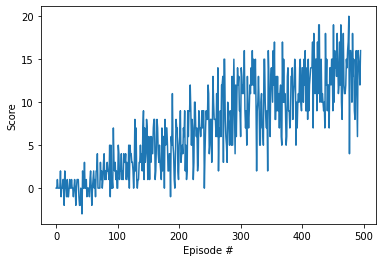

In [9]:
class Env(object):
    """
    Helper Class for translating Unity env to gym env.
    """
    def __init__(self, unity_env, train_mode=True):
        """Constructor for environment helper class.

        Params
        ======
            unity_env (object): unity environment object
            train_mode (bool): start the unity environment in training mode
        """
        self.env = unity_env
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        self.env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        self.state_size = len(self.env_info.vector_observations[0])
        self.train_mode = train_mode

    def reset(self):
        """Reset the unity environment state
        """
        self.env_info = self.env.reset(train_mode=self.train_mode)[self.brain_name]
        return self.env_info.vector_observations[0]

    def step(self, action):
        """Take a step in the unity environment.

        Params
        ======
            action (int): action selected by agent
        """
        self.env_info = self.env.step(action)[self.brain_name]        # send the action to the environment
        next_state = self.env_info.vector_observations[0]   # get the next state
        reward = self.env_info.rewards[0]                   # get the reward
        done = self.env_info.local_done[0]
        return next_state, reward, done, None


env = Env(unity_env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_score=200):
    """Run a Deep Q-Learning training loop.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_score (float): stop the training early if the average score over a window
                              is higher than target_score
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

    return scores

# Begin training
scores = dqn(n_episodes=2000, target_score=13.0)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Evaluate

As shown previously, the agent solves the environment in ~500 episodes. If you have the unity window open and enabled in the environment, then you can run the cell below to watch your trained agent collect bananas.

In [10]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = unity_env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)        # select an action
    env_info = unity_env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

Don't forget to close the environment when you're done.

In [11]:
# close environment
unity_env.close()

### Ideas for future work

While this DQN implementation solves this environment fairly well, there are still many areas for improvement. Future work could consider incorporating multi-step bootstrap targets or prioritized experience replay. The DQN could also be modified to include a Distributional DQN or a Noisy DQN. All of those methods could be combined, an example being the Rainbow algorithm. This example ws solved using trial and error by the author, but hyperparamter tuning both the networks and the RL algorithm as a whole could lead to better results.